# **Data Preparation**

In this section, we first cleaned our data and saved it as CSV files to prepare it for machine learning models. We then performed exploratory data analysis (EDA) on both the positive and negative datasets.

After plotting the n-grams, we observed that common words such as "ive", "ever", and "seen" appeared frequently across both datasets. Since these words are ubiquitous and do not carry strong sentiment signals, removing them could reduce noise and help the model focus on more meaningful features.

Importantly, we didn't remove these extra stop words arbitrarily. We analyzed their relative proportions in both the positive and negative datasets using a function which calculates the relative frequencies and compared them using a defined threshold (a 10% variation in our case). Words with similar proportions across both datasets are considered neutral, as they do not provide significant discriminative power for sentiment analysis. Removing these neutral bigrams allows the model to concentrate on more informative features.

We created two versions of the dataset:

1. One with standard stop words removed.

2. One with additional, less informative words removed.

In the next notebook, we experimented with various machine learning algorithms using both datasets to determine which preprocessing approach produced better results.


## Downloading and Importing Libraries
We import necessary libraries for data manipulation, text processing, visualization, etc.

In [ ]:
!pip install wordcloud

In [ ]:
import pandas as pd
import glob
import os
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading dataset

In [ ]:
# Retrieves data from text files that match a given file path pattern.
# It reads each file, extracts the file name and its content, and stores them in a DataFrame.
def get_data(file_path):
    files = glob.glob(file_path)
    data = []
    for file in files:
        file_name = os.path.basename(file)
        with open(file, 'r', encoding='utf-8') as f:
            content = f.read()
        data.append({'FileName': file_name, 'Content': content})
    return pd.DataFrame(data)

pos_file_path = '/content/drive/MyDrive/it1244/pos/*.txt'
neg_file_path = '/content/drive/MyDrive/it1244/neg/*.txt'

pos_unclean_df = get_data(pos_file_path)
neg_unclean_df = get_data(neg_file_path)

In [ ]:
print(pos_unclean_df.head())

    FileName                                            Content
0  24556.txt  My favorite part of this film was the old man'...
1  22787.txt  Unlike some comments, mine is positive. This m...
2  24575.txt  Very different topic treated in this film. A s...
3  22772.txt  50 years old, this musical comedy fantasy migh...
4  23617.txt  This is an important film. It challenges the v...


In [ ]:
print(neg_unclean_df.head())

    FileName                                            Content
0  23129.txt  Not even Goebbels could have pulled off a prop...
1  22912.txt  A plot that fizzled and reeked of irreconcilab...
2  23622.txt  The first look on the cover of this picture, i...
3  23637.txt  A drama at its very core, "Anna" displays that...
4  23109.txt  When THE MAGIC OF LASSIE opened at Radio City ...


Checking for empty files and duplicates.

In [ ]:
# Identify positive and negative reviews that are empty (only whitespace or blank).
empty_pos = pos_unclean_df[pos_unclean_df['Content'].str.strip() == '']
print(f"Empty positive reviews: {len(empty_pos)}")

empty_neg = neg_unclean_df[neg_unclean_df['Content'].str.strip() == '']
print(f"Empty negative reviews: {len(empty_neg)}")

Empty positive reviews: 0
Empty negative reviews: 0


In [ ]:
print(len(pos_unclean_df))
print(len(neg_unclean_df))

25000
25000


## Cleaning dataset

In [ ]:
# We clean the input text by:
# 1. Removing HTML tags using BeautifulSoup.
# 2. Converting the text to lowercase.
# 3. Removing non-alphabetic characters (keeping only letters and whitespace).
# 4. Replacing multiple spaces with a single space and stripping leading/trailing spaces.
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(clean_text)
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(clean_text)

print("Positive dataset (cleaned):")
print(pos_unclean_df[['FileName', 'Cleaned_Content']].head())

print("\nNegative dataset (cleaned):")
print(neg_unclean_df[['FileName', 'Cleaned_Content']].head())

# Save the cleaned positive dataset to your drive under the name "cleanedposfull.csv"
pos_unclean_df[['FileName', 'Cleaned_Content']].to_csv('/content/drive/MyDrive/it1244/cleanedposfull.csv', index=False)

# Save the cleaned negative dataset to your drive under the name "cleanednegfull.csv"
neg_unclean_df[['FileName', 'Cleaned_Content']].to_csv('/content/drive/MyDrive/it1244/cleanednegfull.csv', index=False)




Positive dataset (cleaned):
    FileName                                    Cleaned_Content
0  24556.txt  my favorite part of this film was the old mans...
1  22787.txt  unlike some comments mine is positive this mov...
2  24575.txt  very different topic treated in this film a st...
3  22772.txt  years old this musical comedy fantasy might lo...
4  23617.txt  this is an important film it challenges the vi...

Negative dataset (cleaned):
    FileName                                    Cleaned_Content
0  23129.txt  not even goebbels could have pulled off a prop...
1  22912.txt  a plot that fizzled and reeked of irreconcilab...
2  23622.txt  the first look on the cover of this picture it...
3  23637.txt  a drama at its very core anna displays that ge...
4  23109.txt  when the magic of lassie opened at radio city ...


Load the new data file

In [ ]:
pos_df = pd.read_csv('/content/drive/MyDrive/it1244/cleanedposfull.csv')
neg_df = pd.read_csv('/content/drive/MyDrive/it1244/cleanednegfull.csv')

## Tokenization & Lemmatization

We tokenize and lemmatize the text to its base form for each review.

In [ ]:
# Tokenize the cleaned content for both positive and negative datasets.
# This creates a new column 'Tokens' by applying nltk.word_tokenize on the 'Cleaned_Content' column.

pos_df['Tokens'] = pos_df['Cleaned_Content'].apply(nltk.word_tokenize)
neg_df['Tokens'] = neg_df['Cleaned_Content'].apply(nltk.word_tokenize)

print("Positive Tokens after Tokenization:")
print(pos_df[['FileName', 'Tokens']].head())

print("\nNegative Tokens after Tokenization:")
print(neg_df[['FileName', 'Tokens']].head())

# Lemmatizes the list of tokens.
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

pos_df['Tokens'] = pos_df['Tokens'].apply(lemmatize_tokens)
neg_df['Tokens'] = neg_df['Tokens'].apply(lemmatize_tokens)

print("\nPositive Tokens after Lemmatization:")
print(pos_df[['FileName', 'Tokens']].head())

print("\nNegative Tokens after Lemmatization:")
print(neg_df[['FileName', 'Tokens']].head())


Positive Tokens after Tokenization:
    FileName                                             Tokens
0  24556.txt  [my, favorite, part, of, this, film, was, the,...
1  22787.txt  [unlike, some, comments, mine, is, positive, t...
2  24575.txt  [very, different, topic, treated, in, this, fi...
3  22772.txt  [years, old, this, musical, comedy, fantasy, m...
4  23617.txt  [this, is, an, important, film, it, challenges...

Negative Tokens after Tokenization:
    FileName                                             Tokens
0  23129.txt  [not, even, goebbels, could, have, pulled, off...
1  22912.txt  [a, plot, that, fizzled, and, reeked, of, irre...
2  23622.txt  [the, first, look, on, the, cover, of, this, p...
3  23637.txt  [a, drama, at, its, very, core, anna, displays...
4  23109.txt  [when, the, magic, of, lassie, opened, at, rad...

Positive Tokens after Lemmatization:
    FileName                                             Tokens
0  24556.txt  [my, favorite, part, of, this, film, wa, th

# Exploratory Data Analysis

We create word clouds and do N-gram analysis on both the positive and negative datasets to get a better idea of the words we will encounter in the dataset.

## Word Clouds

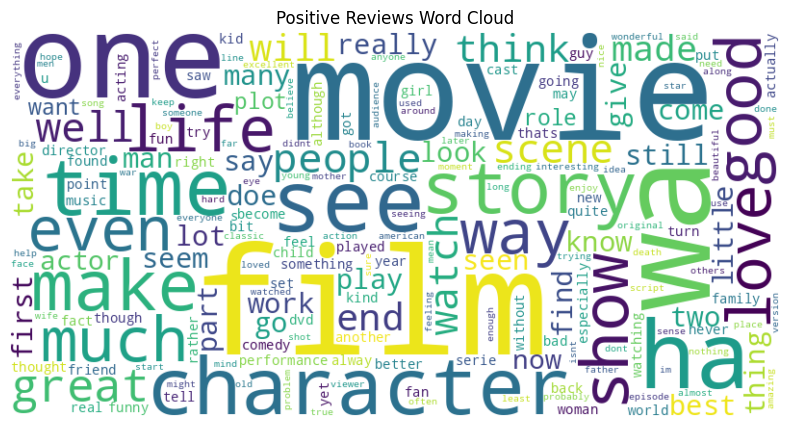

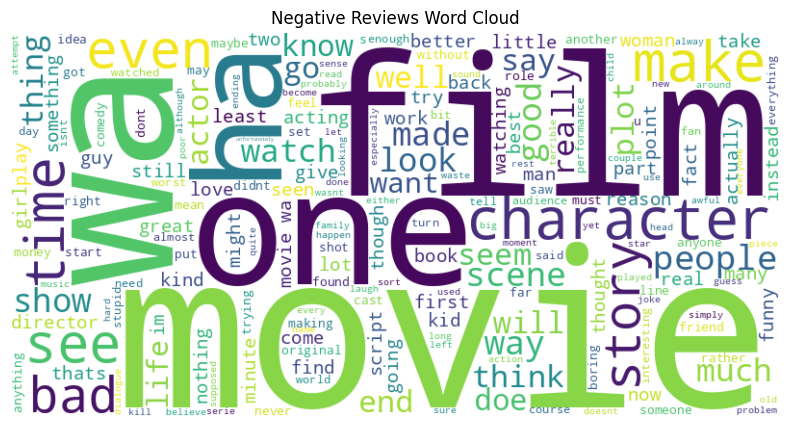

In [ ]:
# Word Cloud
def plot_wordcloud(tokens, title):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_tokens = sum(pos_df['Tokens'].tolist(), [])
negative_tokens = sum(neg_df['Tokens'].tolist(), [])

plot_wordcloud(positive_tokens, "Positive Reviews Word Cloud")
plot_wordcloud(negative_tokens, "Negative Reviews Word Cloud")



## Removing stop words

Since stop words includes "not" or "no", we decided to define a custom stopwords list to filter out tokens from our dataset by removing default stopwords but keeping negation words that are important for sentiment analysis.

In [ ]:
# Retrieve the default English stop words using nltk's stopwords module.
default_stop_words = set(stopwords.words('english'))

# Define a set of important words that we want to keep even if they are stop words.
important_words = {'not', 'no'}

# Create a custom stop words set by removing the important words from the default stop words.
custom_stop_words = default_stop_words - important_words

print("Default Stop Words:", list(default_stop_words))
print("Custom Stop Words:", list(custom_stop_words))


Default Stop Words: ['couldn', 'what', 'once', 'his', 'does', 'some', 'above', 'most', 'myself', 'ours', 'down', 'to', "i'd", 'whom', 'no', "i'm", 'be', 'hasn', 'their', 'yours', 'after', 'at', 'more', 'yourselves', 'any', 'himself', "wasn't", 'when', 'an', 'which', 'of', 'before', 'aren', 'were', 'been', 'ma', 'not', 'them', 'where', "shouldn't", 'theirs', "they're", 'shan', 'it', "haven't", 'having', "we'd", "they'd", 'mightn', "shan't", "doesn't", 'all', "you'd", 'out', "we've", 'such', 'o', 'they', 'there', 'd', 'needn', "he'd", 'ain', 'haven', "aren't", 'own', 'then', 'now', 'this', 'so', 'is', 'and', 'because', 'than', 'hadn', "she'd", "you're", 'm', 'under', 'from', 'her', 'for', 's', "you'll", 'through', 'with', 'about', 'being', "needn't", 'do', 'each', 'yourself', 'but', 'just', 'have', 'other', "we'll", "he's", 'into', 'herself', "it's", 've', "couldn't", 'my', "hasn't", 'wouldn', "should've", 'nor', 'only', 'y', 'during', 'very', 'doesn', 'that', 'by', 'few', 'was', 'same',

Applying the stop words removal

In [ ]:
# Apply stop words removal
def remove_custom_stop_words(tokens, stop_words=custom_stop_words):
    return [token for token in tokens if token not in stop_words]

pos_df['Filtered_Tokens'] = pos_df['Tokens'].apply(remove_custom_stop_words)
neg_df['Filtered_Tokens'] = neg_df['Tokens'].apply(remove_custom_stop_words)

print("Filtered Positive Tokens:")
print(pos_df[['FileName', 'Filtered_Tokens']].head())
print("\nFiltered Negative Tokens:")
print(neg_df[['FileName', 'Filtered_Tokens']].head())

Filtered Positive Tokens:
    FileName                                    Filtered_Tokens
0  24556.txt  [favorite, part, film, wa, old, man, attempt, ...
1  22787.txt  [unlike, comment, mine, positive, movie, wrap,...
2  24575.txt  [different, topic, treated, film, straightforw...
3  22772.txt  [year, old, musical, comedy, fantasy, might, l...
4  23617.txt  [important, film, challenge, viewer, encourage...

Filtered Negative Tokens:
    FileName                                    Filtered_Tokens
0  23129.txt  [not, even, goebbels, could, pulled, propagand...
1  22912.txt  [plot, fizzled, reeked, irreconcilable, differ...
2  23622.txt  [first, look, cover, picture, look, like, good...
3  23637.txt  [drama, core, anna, display, genuine, truth, a...
4  23109.txt  [magic, lassie, opened, radio, city, music, ha...


In [ ]:
# save the version regular stopwords removed

pos_df['Cleaned_Text'] = pos_df['Filtered_Tokens'].apply(lambda tokens: ' '.join(tokens))
neg_df['Cleaned_Text'] = neg_df['Filtered_Tokens'].apply(lambda tokens: ' '.join(tokens))

pos_df[['FileName', 'Cleaned_Text']].to_csv('/content/drive/MyDrive/it1244/cleaned_pos_reviews_regular_stopwords.csv', index=False)
neg_df[['FileName', 'Cleaned_Text']].to_csv('/content/drive/MyDrive/it1244/cleaned_neg_reviews_regular_stopwords.csv', index=False)


## N-gram Frequency Analysis (Filtered Data)


In [ ]:
# Function to calculate n-gram frequencies from a list of tokens.
def get_ngram_frequencies(tokens_list, n):
    ngram_list = list(ngrams(tokens_list, n))
    return Counter(ngram_list)

pos_all_tokens = [token for tokens in pos_df['Tokens'] for token in tokens]
neg_all_tokens = [token for tokens in neg_df['Tokens'] for token in tokens]

# Function to plot the frequency of n-grams.
def plot_ngram_frequency(counter, title, n=10):
    most_common = counter.most_common(n)
    labels, values = zip(*most_common)
    labels = [' '.join(label) for label in labels]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha="right")

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
pos_all_filtered_tokens = [token for tokens in pos_df['Filtered_Tokens'] for token in tokens]
neg_all_filtered_tokens = [token for tokens in neg_df['Filtered_Tokens'] for token in tokens]

Unigram for positive and negative dataset

Top 10 Unigrams in Positive Reviews (Filtered):
[(('film',), 47894), (('wa',), 43175), (('movie',), 43133), (('not',), 28793), (('one',), 26958), (('ha',), 17971), (('like',), 17541), (('time',), 15197), (('good',), 14419), (('story',), 13648)]

Top 10 Unigrams in Negative Reviews (Filtered):
[(('movie',), 55893), (('wa',), 52032), (('film',), 41915), (('not',), 32812), (('one',), 25719), (('like',), 22249), (('no',), 15368), (('ha',), 15183), (('even',), 14921), (('time',), 14200)]


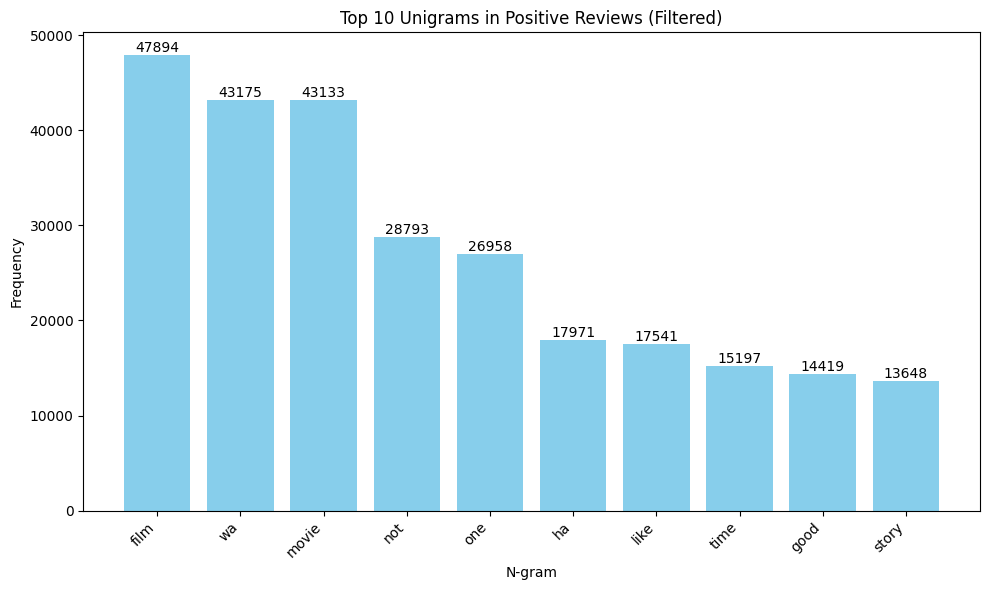

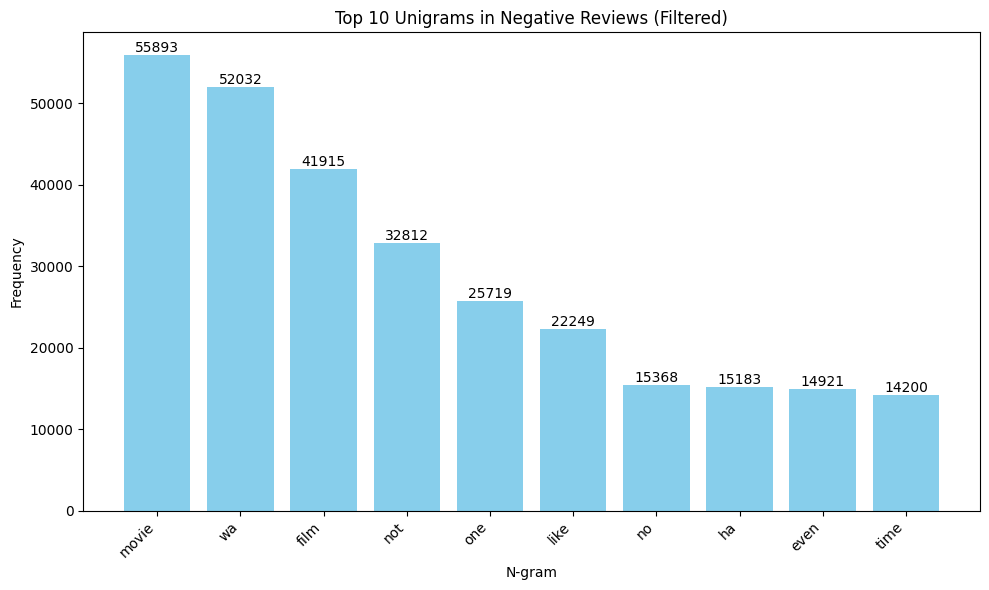

In [ ]:
# Calculate the frequency of unigrams (single words) from the filtered positive and negative tokens.
pos_unigrams_filtered = get_ngram_frequencies(pos_all_filtered_tokens, 1)
neg_unigrams_filtered = get_ngram_frequencies(neg_all_filtered_tokens, 1)

print("Top 10 Unigrams in Positive Reviews (Filtered):")
print(pos_unigrams_filtered.most_common(10))
print("\nTop 10 Unigrams in Negative Reviews (Filtered):")
print(neg_unigrams_filtered.most_common(10))

plot_ngram_frequency(pos_unigrams_filtered, "Top 10 Unigrams in Positive Reviews (Filtered)")
plot_ngram_frequency(neg_unigrams_filtered, "Top 10 Unigrams in Negative Reviews (Filtered)")

Determining stop words to remove from unigram

In [ ]:
# Top 10 unigrams from both sets
top_pos_unigrams = pos_unigrams_filtered.most_common(10)
top_neg_unigrams = neg_unigrams_filtered.most_common(10)

pos_dict = dict(top_pos_unigrams)
neg_dict = dict(top_neg_unigrams)

# Total counts (for relative frequency)
total_pos = sum(freq for _, freq in top_pos_unigrams)
total_neg = sum(freq for _, freq in top_neg_unigrams)

# Compare proportions
similar_words = []
threshold = 0.1  # Allow 10% variation in proportion

print("Word\t\tRelFreq_Pos\tRelFreq_Neg\tRatio")

for word in pos_dict:
    if word in neg_dict:
        rel_pos = pos_dict[word] / total_pos
        rel_neg = neg_dict[word] / total_neg
        ratio = rel_pos / rel_neg if rel_neg != 0 else float('inf')

        print(f"{word[0]:<10}\t{rel_pos:.4f}\t\t{rel_neg:.4f}\t\t{ratio:.2f}")

        # If relative proportions are similar, mark as neutral
        if 1 - threshold < ratio < 1 + threshold:
            similar_words.append(word[0])

print("\nNeutral (similar) words to remove:")
print(similar_words)

Word		RelFreq_Pos	RelFreq_Neg	Ratio
film      	0.1782		0.1444		1.23
wa        	0.1607		0.1792		0.90
movie     	0.1605		0.1925		0.83
not       	0.1071		0.1130		0.95
one       	0.1003		0.0886		1.13
ha        	0.0669		0.0523		1.28
like      	0.0653		0.0766		0.85
time      	0.0566		0.0489		1.16

Neutral (similar) words to remove:
['not']


Bigram for positive and negative dataset


Top 10 Bigrams in Positive Reviews (Filtered):
[(('movie', 'wa'), 2135), (('film', 'wa'), 1797), (('one', 'best'), 1614), (('doe', 'not'), 1223), (('wa', 'not'), 1112), (('ive', 'seen'), 1053), (('even', 'though'), 1016), (('film', 'ha'), 932), (('ever', 'seen'), 915), (('first', 'time'), 910)]

Top 10 Bigrams in Negative Reviews (Filtered):
[(('movie', 'wa'), 3761), (('look', 'like'), 2152), (('film', 'wa'), 2126), (('ever', 'seen'), 1617), (('special', 'effect'), 1414), (('doe', 'not'), 1410), (('wa', 'not'), 1392), (('not', 'even'), 1377), (('waste', 'time'), 1361), (('dont', 'know'), 1192)]


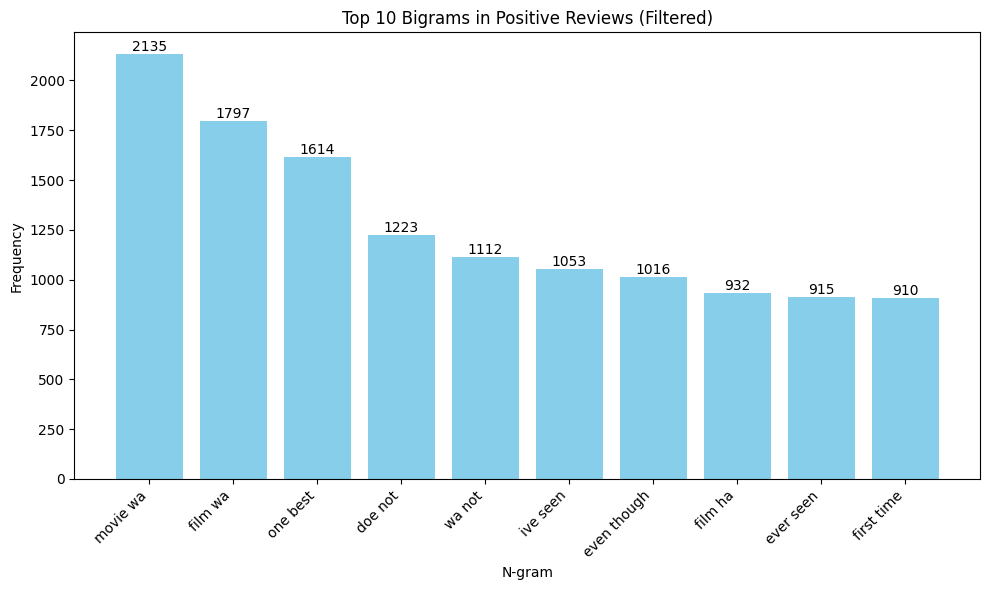

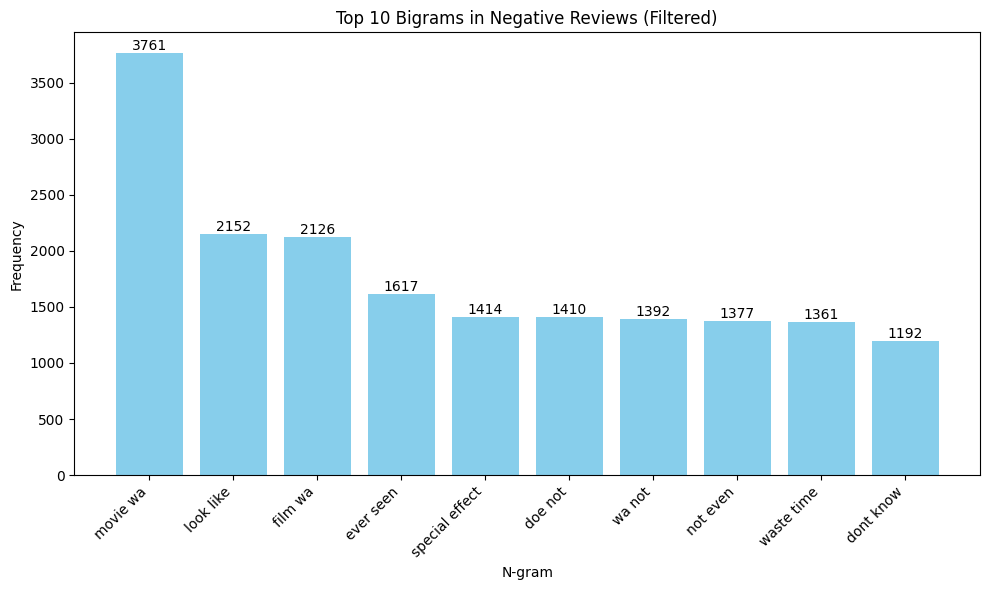

In [ ]:
# Calculate the frequency of bigrams from the filtered positive and negative tokens.

pos_bigrams_filtered = get_ngram_frequencies(pos_all_filtered_tokens, 2)
neg_bigrams_filtered = get_ngram_frequencies(neg_all_filtered_tokens, 2)


print("\nTop 10 Bigrams in Positive Reviews (Filtered):")
print(pos_bigrams_filtered.most_common(10))
print("\nTop 10 Bigrams in Negative Reviews (Filtered):")
print(neg_bigrams_filtered.most_common(10))

plot_ngram_frequency(pos_bigrams_filtered, "Top 10 Bigrams in Positive Reviews (Filtered)")
plot_ngram_frequency(neg_bigrams_filtered, "Top 10 Bigrams in Negative Reviews (Filtered)")

Determining stop words to remove from bigram

In [ ]:
# Top 10 bigrams from both sets
top_pos_bigrams = pos_bigrams_filtered.most_common(10)
top_neg_bigrams = neg_bigrams_filtered.most_common(10)

pos_dict = dict(top_pos_bigrams)
neg_dict = dict(top_neg_bigrams)

# Total counts (for relative frequency)
total_pos = sum(freq for _, freq in top_pos_bigrams)
total_neg = sum(freq for _, freq in top_neg_bigrams)

# Compare proportions
similar_bigrams = []
threshold = 0.1  # Allow 10% variation in proportion

print("Bigram\t\t\tRelFreq_Pos\tRelFreq_Neg\tRatio")

for bigram in pos_dict:
    if bigram in neg_dict:
        rel_pos = pos_dict[bigram] / total_pos
        rel_neg = neg_dict[bigram] / total_neg
        ratio = rel_pos / rel_neg if rel_neg != 0 else float('inf')

        print(f"{' '.join(bigram):<20}\t{rel_pos:.4f}\t\t{rel_neg:.4f}\t\t{ratio:.2f}")

        # If relative proportions are similar, mark as neutral
        if 1 - threshold < ratio < 1 + threshold:
            similar_bigrams.append(bigram)

print("\nNeutral (similar) bigrams to remove:")
print(similar_bigrams)


Bigram			RelFreq_Pos	RelFreq_Neg	Ratio
movie wa            	0.1680		0.2113		0.80
film wa             	0.1414		0.1194		1.18
doe not             	0.0962		0.0792		1.22
wa not              	0.0875		0.0782		1.12
ever seen           	0.0720		0.0908		0.79

Neutral (similar) bigrams to remove:
[]


Trigram for positive and negative dataset


Top 10 Trigrams in Positive Reviews (Filtered):
[(('ive', 'ever', 'seen'), 349), (('new', 'york', 'city'), 187), (('im', 'not', 'sure'), 179), (('film', 'ive', 'seen'), 156), (('one', 'best', 'movie'), 154), (('world', 'war', 'ii'), 153), (('film', 'ever', 'made'), 146), (('one', 'best', 'film'), 145), (('movie', 'ever', 'seen'), 139), (('doe', 'good', 'job'), 137)]

Top 10 Trigrams in Negative Reviews (Filtered):
[(('ive', 'ever', 'seen'), 639), (('worst', 'movie', 'ever'), 554), (('movie', 'ever', 'seen'), 373), (('one', 'worst', 'movie'), 320), (('dont', 'waste', 'time'), 309), (('movie', 'ive', 'ever'), 274), (('im', 'not', 'sure'), 274), (('worst', 'film', 'ever'), 260), (('worst', 'movie', 'ive'), 233), (('movie', 'ever', 'made'), 223)]


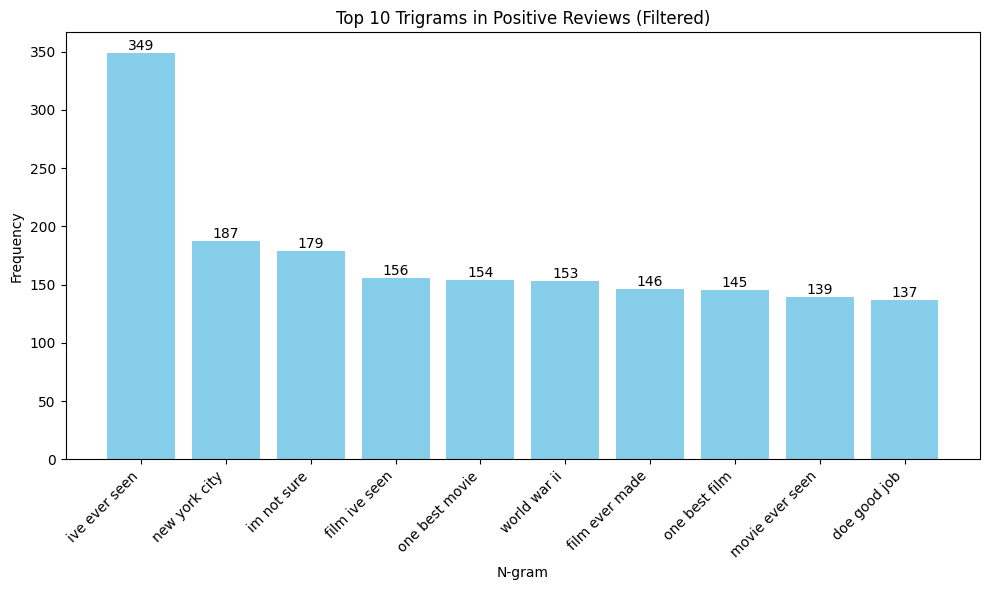

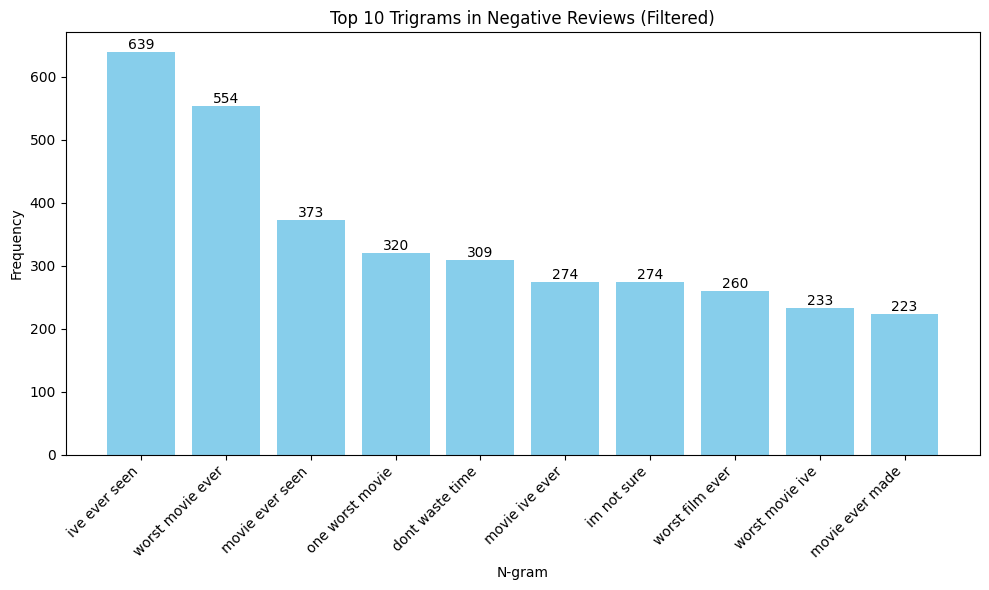

In [ ]:
# Calculate the frequency of trigrams from the filtered positive and negative tokens.

pos_trigrams_filtered = get_ngram_frequencies(pos_all_filtered_tokens, 3)
neg_trigrams_filtered = get_ngram_frequencies(neg_all_filtered_tokens, 3)

print("\nTop 10 Trigrams in Positive Reviews (Filtered):")
print(pos_trigrams_filtered.most_common(10))
print("\nTop 10 Trigrams in Negative Reviews (Filtered):")
print(neg_trigrams_filtered.most_common(10))

plot_ngram_frequency(pos_trigrams_filtered, "Top 10 Trigrams in Positive Reviews (Filtered)")
plot_ngram_frequency(neg_trigrams_filtered, "Top 10 Trigrams in Negative Reviews (Filtered)")

Determining the stop words to remove from trigram

In [ ]:
# Top 10 trigrams from both sets
top_pos_trigrams = pos_trigrams_filtered.most_common(10)
top_neg_trigrams = neg_trigrams_filtered.most_common(10)

pos_dict = dict(top_pos_trigrams)
neg_dict = dict(top_neg_trigrams)

# Total counts (for relative frequency)
total_pos = sum(freq for _, freq in top_pos_trigrams)
total_neg = sum(freq for _, freq in top_neg_trigrams)

# Compare proportions
similar_trigrams = []
threshold = 0.1  # Allow 10% variation in proportion

print("Trigram\t\t\t\tRelFreq_Pos\tRelFreq_Neg\tRatio")

for trigram in pos_dict:
    if trigram in neg_dict:
        rel_pos = pos_dict[trigram] / total_pos
        rel_neg = neg_dict[trigram] / total_neg
        ratio = rel_pos / rel_neg if rel_neg != 0 else float('inf')

        print(f"{' '.join(trigram):<30}\t{rel_pos:.4f}\t\t{rel_neg:.4f}\t\t{ratio:.2f}")

        # If relative proportions are similar, mark as neutral
        if 1 - threshold < ratio < 1 + threshold:
            similar_trigrams.append(trigram)

print("\nNeutral (similar) trigrams to remove:")
print(similar_trigrams)


Trigram				RelFreq_Pos	RelFreq_Neg	Ratio
ive ever seen                 	0.2000		0.1847		1.08
im not sure                   	0.1026		0.0792		1.29
movie ever seen               	0.0797		0.1078		0.74

Neutral (similar) trigrams to remove:
[('ive', 'ever', 'seen')]


Applying the stop words removal based on results from unigram, bigram and trigram

In [ ]:
from nltk.util import ngrams

# Words/ngrams to remove
remove_unigrams = {'not'}
remove_trigrams = {('ive', 'ever', 'seen')}

def remove_specific_ngrams(tokens, remove_unigrams=remove_unigrams, remove_trigrams=remove_trigrams):
    # Remove specified unigrams
    filtered = [token for token in tokens if token not in remove_unigrams]

    # Generate trigrams from the filtered list
    trigrams_in_text = list(ngrams(filtered, 3))

    # Identify trigram start indices to remove
    indices_to_remove = set()
    for i in range(len(trigrams_in_text)):
        if trigrams_in_text[i] in remove_trigrams:
            indices_to_remove.update({i, i+1, i+2})

    # Remove trigram tokens
    final_tokens = [token for i, token in enumerate(filtered) if i not in indices_to_remove]

    return final_tokens


pos_df['Cleaned_Tokens'] = pos_df['Filtered_Tokens'].apply(remove_specific_ngrams)
neg_df['Cleaned_Tokens'] = neg_df['Filtered_Tokens'].apply(remove_specific_ngrams)


# Converting Cleaned Files to CSV

We save the cleaned data as csv files so that we can continue with extraction and modeling.

In [ ]:

pos_df['Cleaned_Text'] = pos_df['Cleaned_Tokens'].apply(lambda tokens: ' '.join(tokens))
neg_df['Cleaned_Text'] = neg_df['Cleaned_Tokens'].apply(lambda tokens: ' '.join(tokens))

pos_df[['FileName', 'Cleaned_Text']].to_csv(
    '/content/drive/MyDrive/it1244/cleaned_pos_reviews_extra_stopwords.csv', index=False
)
neg_df[['FileName', 'Cleaned_Text']].to_csv(
    '/content/drive/MyDrive/it1244/cleaned_neg_reviews_extra_stopwords.csv', index=False
)
